In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

perc_test = 0.2
batch_size = 100

# load data and one hot encode some of the non numerical features

df = pd.read_csv("PeerLoanKart_fraud.csv")

df.rename(columns={"Loan Repayment Status": "target"}, inplace=True)
df["target"] = (df["target"]=="Paid")*1
df["ntarget"] = 1 - df["target"]
df = pd.concat((df, pd.get_dummies(df["purpose"], dtype="int")), axis=1)

# Select data and target

features = ['credit_card',
            'debt_consolidation',
            'educational',
            'home_improvement',
            'major_purchase',
            'small_business',
            'log.annual.inc',
            'fico',
            'delinq.2yrs',
            'pub.rec',
#            'credit.policy',
            'int.rate',
            'installment',
            'days.with.cr.line',
            'inq.last.6mths',
            'dti',
            'revol.util',
            'revol.bal',
          ]

target = ['target',
          'ntarget']

X = df[features]
y = df[target]

# Normalize all features that have large deviations

#numerical_features = ['fico',
#                      'log.annual.inc',
#                      'installment',
#                      'days.with.cr.line',
#                      'dti',
#                      'revol.util',
#                      'revol.bal',
#                      'inq.last.6mths',
#                     ]

numerical_features = features

def normalize(X):
    X.loc[:, numerical_features] = (X[numerical_features] - X[numerical_features].mean())/X[numerical_features].std()
    return X

X = normalize(X)

#purposes = ['all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']

#for i, purpose in enumerate(purposes):
#    Xnorm = normalize(X[X[purpose]==1])
#    if i==0:
#        Xcat = Xnorm
#    else:
#        Xcat = pd.concat((Xcat, Xnorm), axis=0)
#X = Xcat


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=perc_test, random_state=123, shuffle=True)

Xt_train = torch.tensor(X_train.values).float()
yt_train = torch.tensor(y_train.values).float()
Xt_test = torch.tensor(X_test.values).float()
yt_test = torch.tensor(y_test.values).float()

train_dataset = TensorDataset(Xt_train, yt_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

{'C': 0.1}


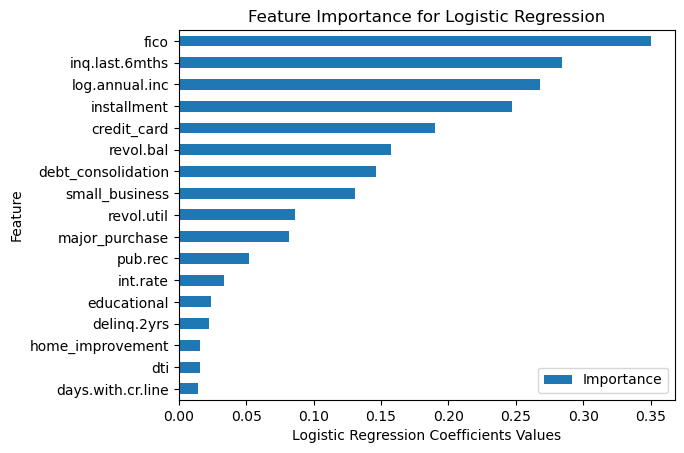

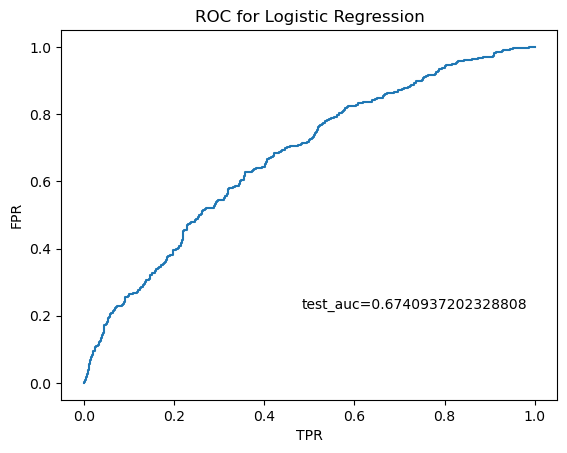

In [52]:
clf = LogisticRegression(random_state=123)
param_grid = {'C': [0.05, 0.1, 0.2]}

gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"])

clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

print(gs.best_params_)

coefficients = clf_best.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for Logistic Regression")
plt.xlabel("Logistic Regression Coefficients Values")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,0])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for Logistic Regression")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

{'max_depth': 6, 'n_estimators': 200}


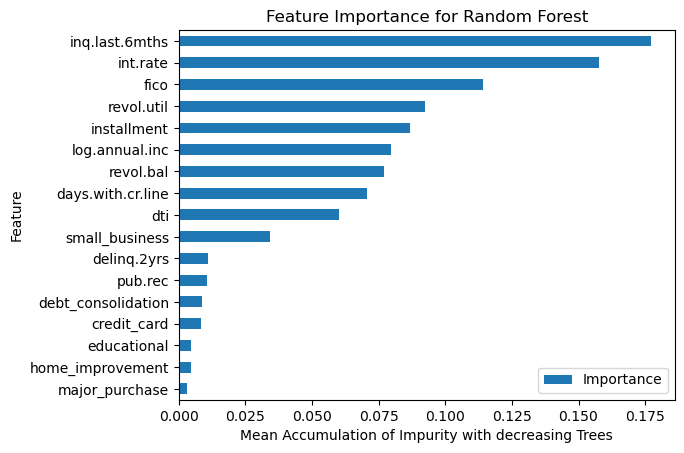

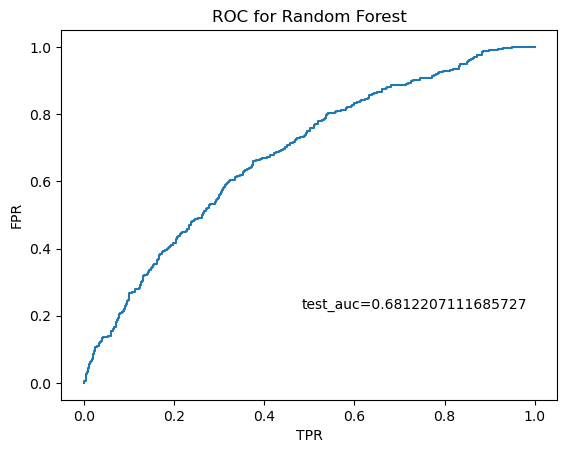

In [55]:
clf = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators':[50, 100, 150, 200],
              'max_depth':[4, 5, 6]}

gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"])

clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

print(gs.best_params_)

coefficients = clf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for Random Forest")
plt.xlabel("Mean Accumulation of Impurity with decreasing Trees")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,0])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for Random Forest")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

{'eta': 0.1, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.005}
num_trees 50


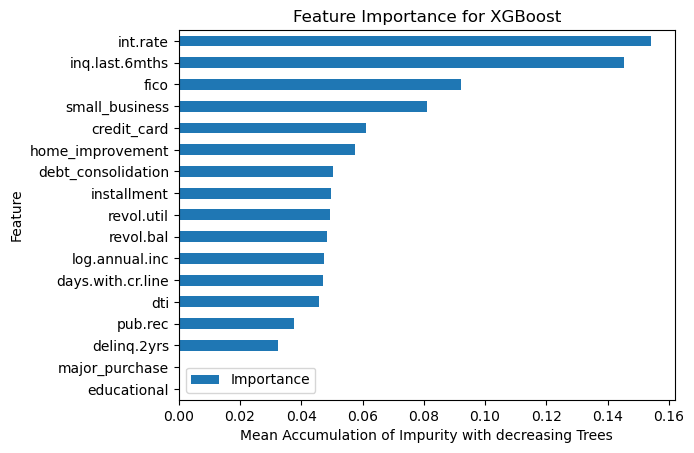

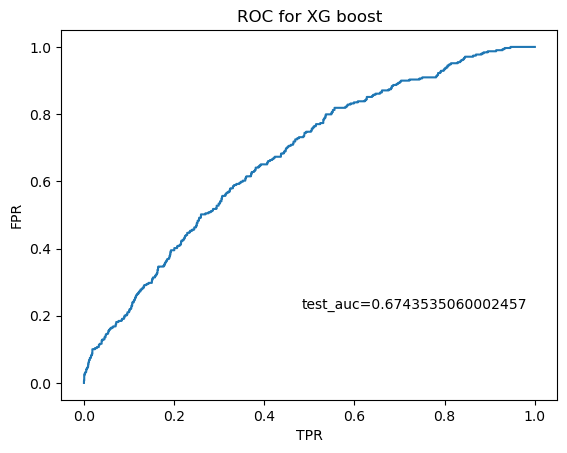

In [61]:
clf = xgb.XGBClassifier(tree_method='auto', seed=123, early_stopping_rounds=20) #reg_lambda=0.01, reg_alpha=0.1, gamma=0.31
param_grid = {'n_estimators': [50, 75, 100],
              'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
              'gamma': [0.1, 0.2, 0.3],
              'max_depth': [3, 4, 5],
              'reg_lambda': [0.005, 0.01, 0.015],
              'reg_alpha': [0.05, 0.1, 0.15]}

gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"], eval_set=[(X_test, y_test["target"])], verbose=False)

clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

print(gs.best_params_)
print('num_trees', len(clf_best.get_booster().get_dump()))

coefficients = clf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for XGBoost")
plt.xlabel("Mean Accumulation of Impurity with decreasing Trees")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,0])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for XG boost")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

In [47]:
import torch
from torch import nn
from torch.nn import functional as F

dropout = 0.1

class SimpleNeuralNet(nn.Module):

    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.dropout1 = nn.Dropout(dropout)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.dropout2 = nn.Dropout(dropout)
        self.output = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = self.dropout1(F.relu(self.hidden1(x)))
        x = x + self.dropout2(F.sigmoid(self.hidden2(x)))
        x = F.softmax(self.output(x), dim=1)
        return x

nnet = SimpleNeuralNet(n_input=17, n_hidden1=8, n_hidden2=8, n_output=2)

optimizer = torch.optim.AdamW(params = nnet.parameters(), lr= 1e-3, weight_decay=1e-3, eps=1e-7)
loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))

n_epochs = 20
N_print = 50

nnet.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (features, target) in enumerate(train_loader, 0):

        optimizer.zero_grad()
        p_train = nnet(features)
        loss = loss_func(p_train, target)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % N_print == (N_print-1):
            print(i, running_loss/N_print)
            running_loss = 0.0

49 0.8916094708442688
49 0.726466611623764
49 0.6806720173358918
49 0.670320279598236
49 0.6642811596393585
49 0.6617678999900818
49 0.6598672533035278
49 0.6569087255001068
49 0.6568926095962524
49 0.6531912076473236
49 0.6540396785736085
49 0.6509369826316833
49 0.6495820236206055
49 0.6499219059944152
49 0.6511868834495544
49 0.6489093172550201
49 0.6498657381534576
49 0.6501090276241303
49 0.6503976213932038
49 0.650064251422882


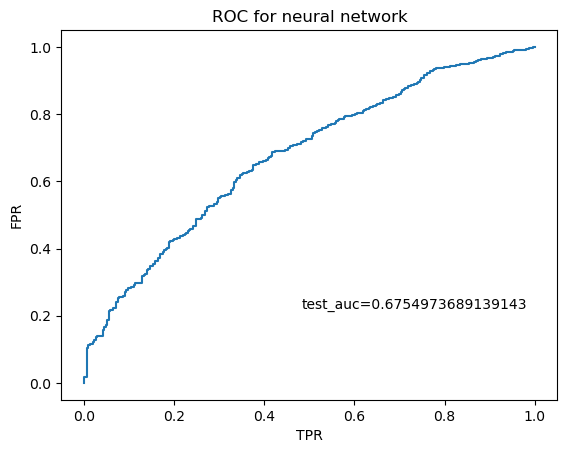

In [48]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

nnet.eval()
p_test = nnet(Xt_test)

y_true = yt_test[:,-1].detach().numpy()
y_score = p_test[:,0].detach().numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_score)
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for neural network")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()